# 자동차 제조 테스트 공정 시간 예측하기

## 분석 프로세스

데이터 출처: [Kaggle] https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data   


**데이터 정보**  


|ID|테스트번호|
|:--:|:--:|
|y|테스트 시간|
|X1-X8|범주형 데이터|
|X10-X385|숫자형 데이터|


### 분석 목표 정의  
> 자동차 제조 테스트 공정 시간 예측하기

### 데이터 수집  
- 테스트별 걸린 시간
- 테스트 값

### 데이터 전처리  
- 결측값 여부
- Target Feature

### 모델 생성  
- 차원 축소 기법 (PCA, ICA, TSVD등) 별 모델링 후 최적 기법 탐색
- Stacked Regression 모델링

### 모델 평가  
- Feature Importance

- matplotlib 한글 깨짐 현상 해결  
> 셀 실행 후 런타임 재시작 필요

In [1]:
# matplotlib 한글깨짐 현상 해결
! apt-get update -qq
! apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = 'NanumGothic'
fe = fm.FontEntry(fname=path, name=font_name)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': font_name})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121666 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 데이터 준비를 위한 EDA 및 전처리

### 0. 데이터 불러오기

In [2]:
# 필요한 파이썬 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

from sklearn import preprocessing
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from sklearn.cluster import FeatureAgglomeration

from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.linear_model import ElasticNet, LassoLarsCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import check_array
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel

seed = 40

import warnings
warnings.filterwarnings('ignore')
color = sns.color_palette()
%matplotlib inline

In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/08_car_manufacturing_test_time_prediction/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/08_car_manufacturing_test_time_prediction/test.csv")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (4209, 378)
Test shape: (4209, 377)


In [4]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


> Feature 데이터
> 1. ID
> 2. y: target Feature
> 3. X0-X385

### 1. Target Feature
> Scatter Plot

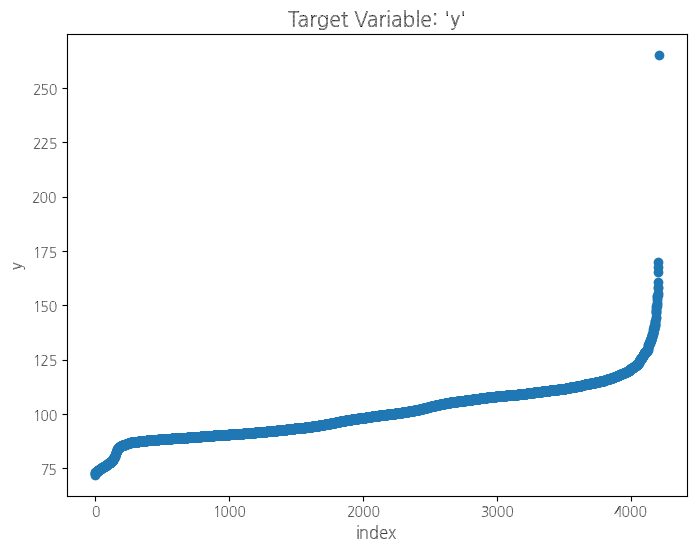

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Target Variable: 'y'", fontsize=15)
plt.show()

> Histogram

<Figure size 1200x800 with 0 Axes>

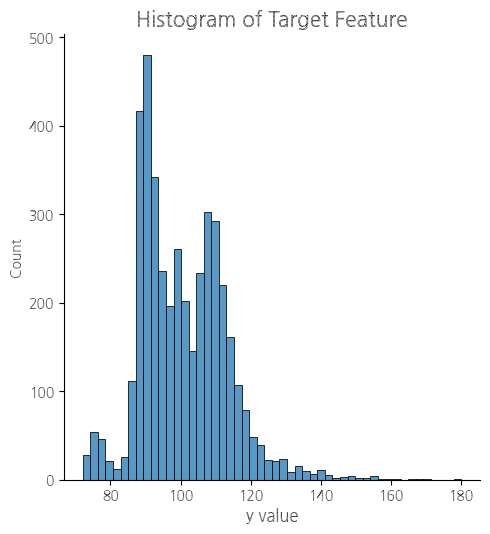

In [6]:
ulimit = 180
train_df['y'].loc[train_df['y'] > ulimit] = ulimit

plt.figure(figsize=(12, 8))
sns.displot(train_df.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize=12)
plt.title('Histogram of Target Feature', fontsize=15)
plt.show()

In [7]:
print(f"최소값: {min(train_df['y'].values)} 최대값: {max(train_df['y'].values)} 평균값: {train_df['y'].values.mean()} 표준편차: {train_df['y'].values.std()}")
print(f"180보다 큰 숫자들 개수: {np.sum(train_df['y'].values > 180)}")

최소값: 72.11 최대값: 180.0 평균값: 100.64904727963888 표준편차: 12.481281731120474
180보다 큰 숫자들 개수: 0


### 데이터 탐색

In [8]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


In [9]:
dtype_df.loc[:10, :]

,Count,Column Type
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


#### 결측값

In [10]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [11]:
cols = [c for c in train_df.columns if 'X' in c]
print('Number of features:', len(cols))
print("Feature types:")
train_df[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

In [12]:
counts = [[], [], []]
for c in cols:
  typ = train_df[c].dtype
  uniq = len(np.unique(train_df[c]))
  if uniq == 1:
    counts[0].append(c)
  elif uniq == 2 and typ == np.int64:
    counts[1].append(c)
  else:
    counts[2].append(c)

print(f"Feature 값이 1개인 경우: {len(counts[0])}\nFeature 값이 2개인 경우: {len(counts[1])}\n범주형 Feature인 경우: {len(counts[2])}")
print("Feature 값이 1개인 경우: ", counts[0])
print("범주형 Feature인 경우: ", counts[2])

Feature 값이 1개인 경우: 12
Feature 값이 2개인 경우: 356
범주형 Feature인 경우: 8
Feature 값이 1개인 경우:  ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
범주형 Feature인 경우:  ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


In [13]:
unique_values_dict = {}
for col in train_df.columns:
  if col not in ["ID", 'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']:
    unique_value = str(np.sort(train_df[col].unique()).tolist())
    tlist = unique_values_dict.get(unique_value, [])
    tlist.append(col)
    unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
  print("컬럼에 존재하는 유일한 값들:", unique_val)   # 유일한 값이 1개이면 의미 없는 피쳐
  print(columns)

컬럼에 존재하는 유일한 값들: [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145', 'X146', 'X147', 'X148

#### 범주형 Features

In [14]:
cat_feat = counts[2]
train_df[cat_feat].head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


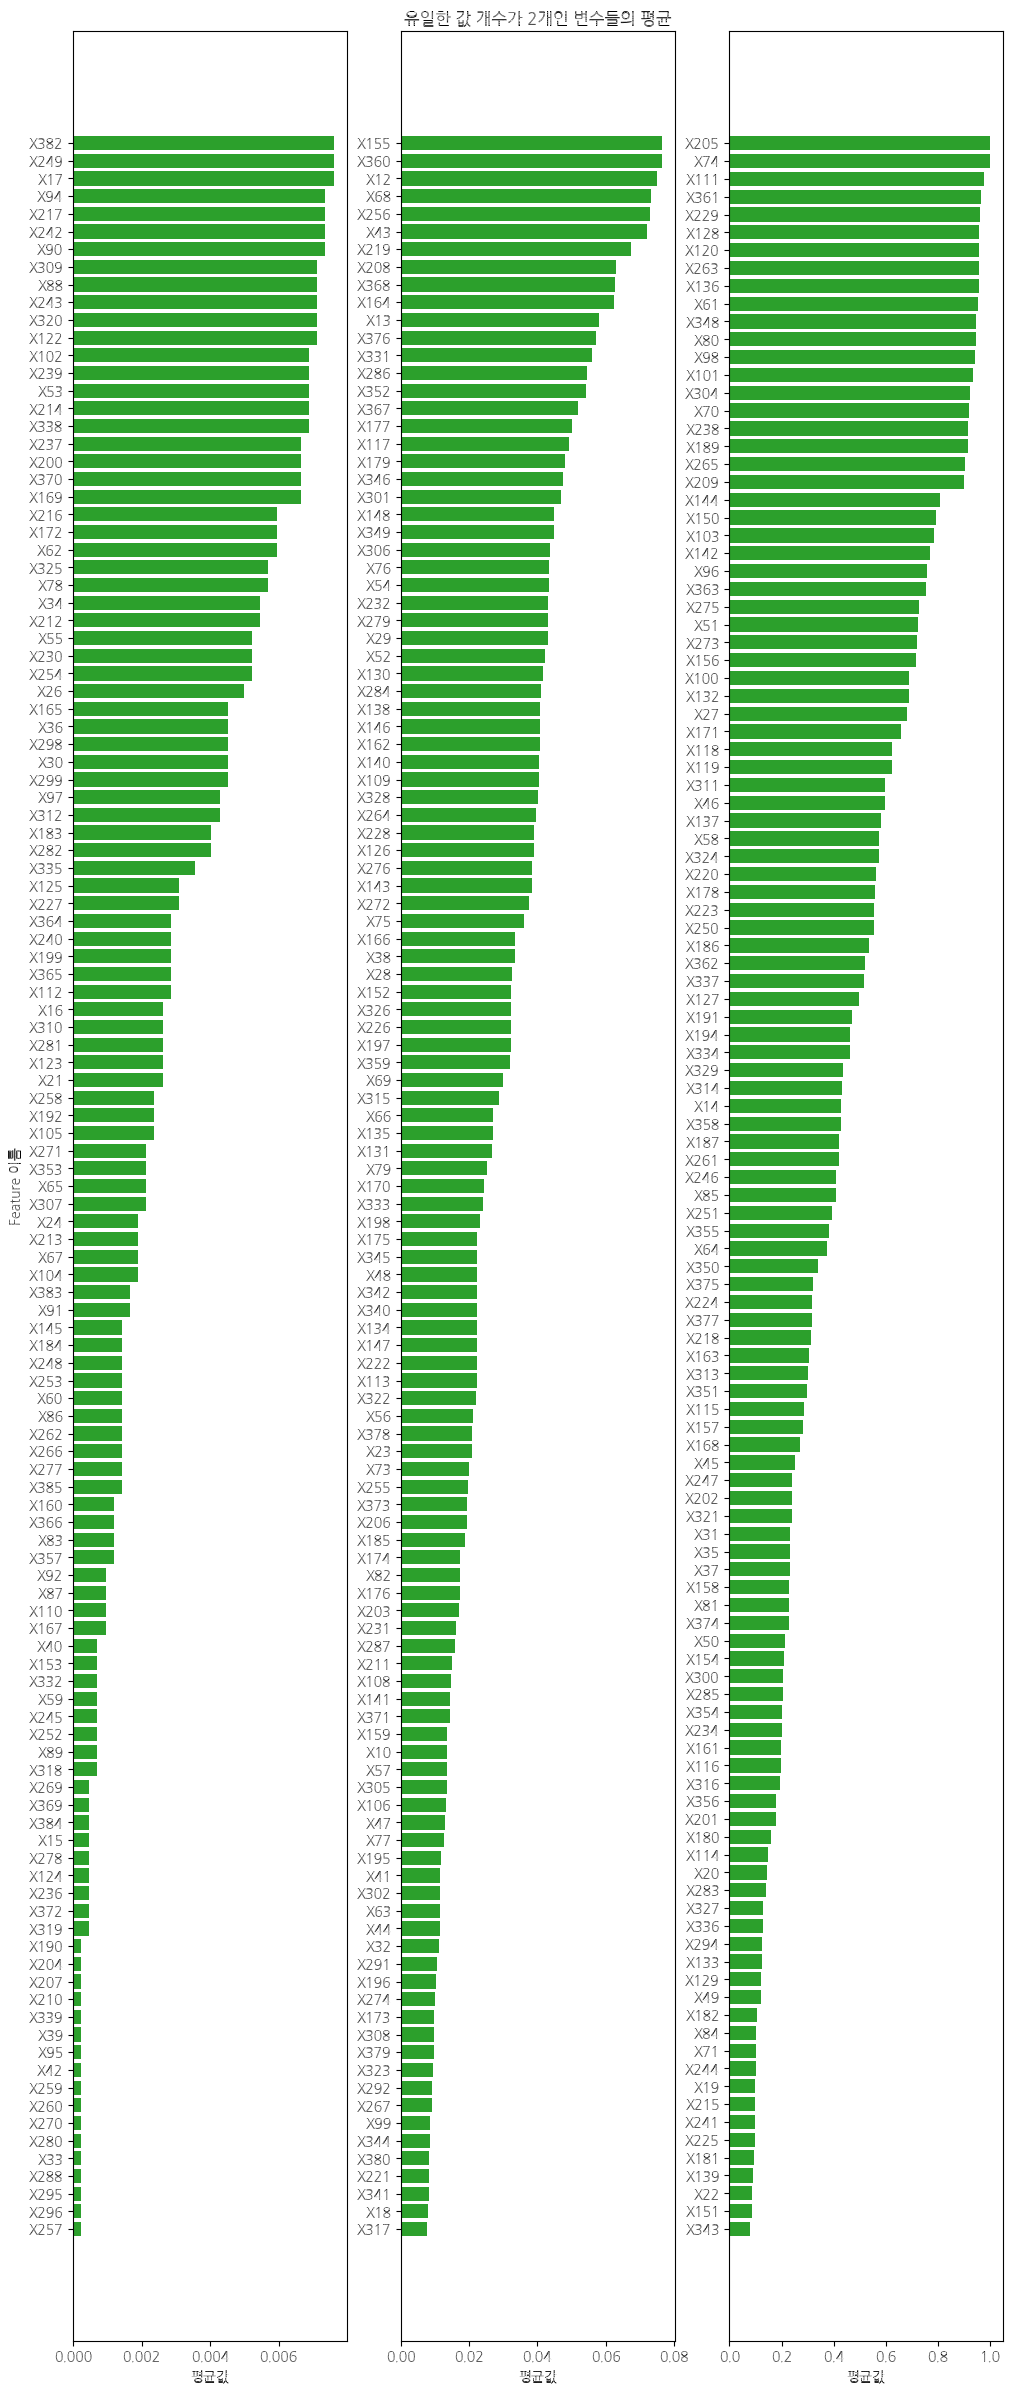

In [15]:

binary_means = [np.mean(train_df[c]) for c in counts[1]]
binary_names = np.array(counts[1])[np.argsort(binary_means)]
binary_means = np.sort(binary_means)

fig, ax = plt.subplots(1, 3, figsize=(12, 30))
ax[0].set_ylabel('Feature 이름')
ax[1].set_title('유일한 값 개수가 2개인 변수들의 평균')
for i in range(3):
  names, means = binary_names[i*119:(i+1)*119], binary_means[i*119:(i+1)*119]
  ax[i].barh(range(len(means)), means, color=color[2])
  ax[i].set_xlabel('평균값')
  ax[i].set_yticks(range(len(means)))
  ax[i].set_yticklabels(names, rotation="horizontal")
plt.show()

## 머신러닝 모델링

### Base Model 1: xgboost model

#### Label Encoding

In [16]:
for f in ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']:
  lbl = preprocessing.LabelEncoder()
  lbl.fit(list(train_df[f].values))
  train_df[f] = lbl.transform(list(train_df[f].values))

#### 데이터 준비

In [17]:
train_y = train_df['y'].values
train_X = train_df.drop(["ID", "y"], axis=1)

#### 모델 생성

In [18]:
def xgb_r2_score(preds, dtrain):
  labels = dtrain.get_label()
  return 'r2', r2_score(labels, preds)

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=list(train_X.columns))
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100, feval=xgb_r2_score, maximize=True)

#### Feature Importances

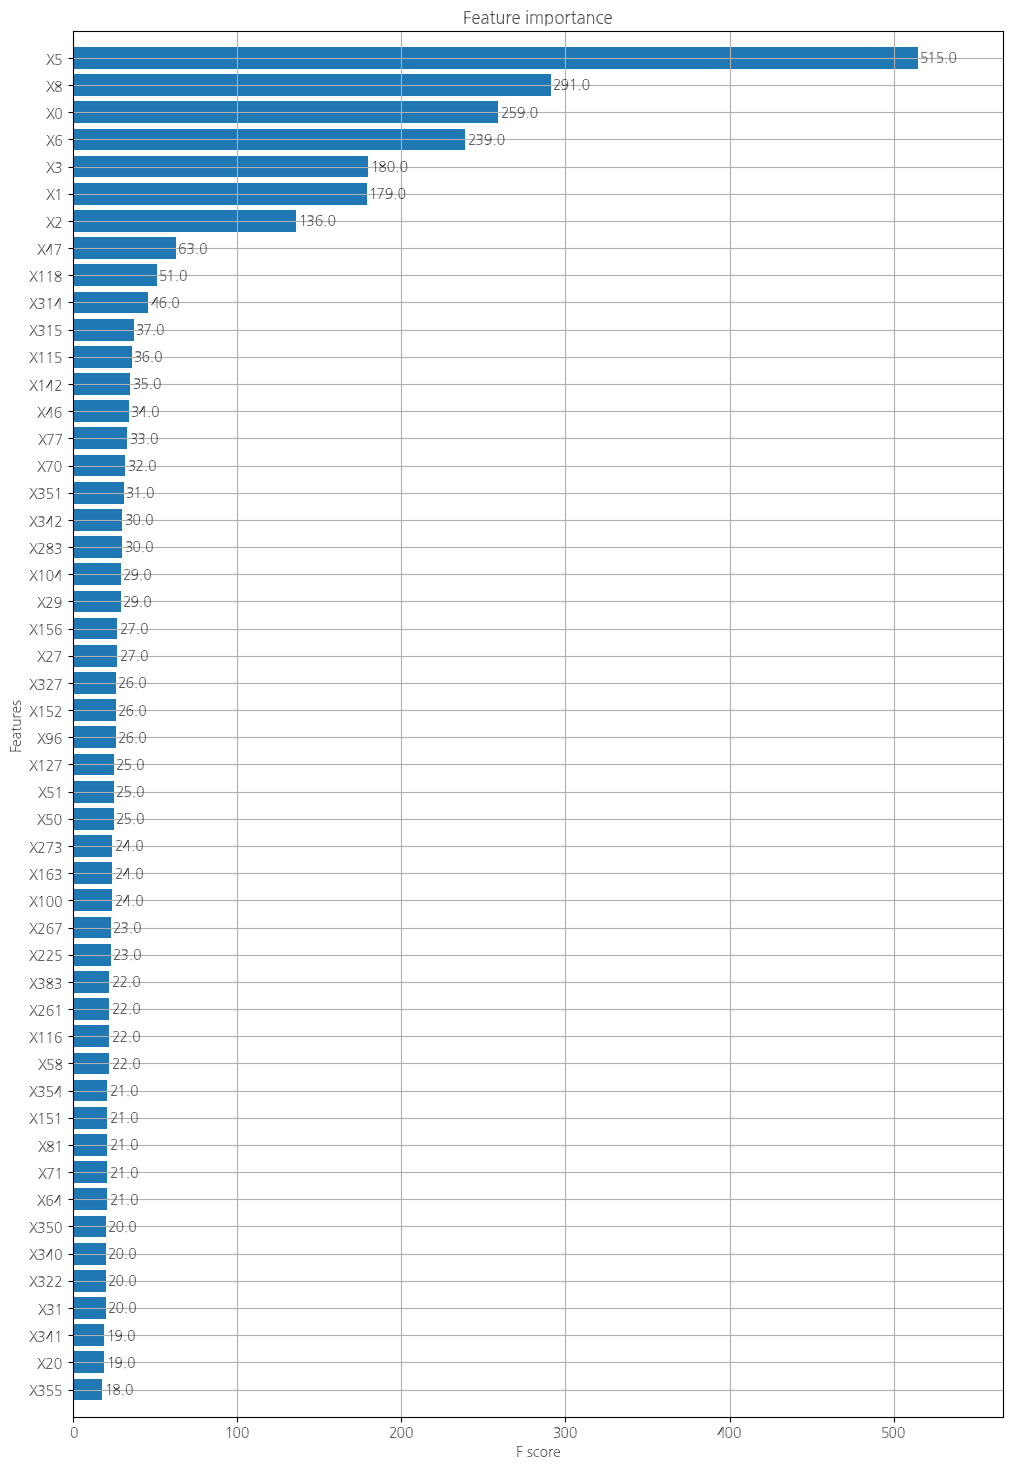

In [19]:
fig, ax = plt.subplots(figsize=(12,18))
# xgb의 Feature Importance 구하기
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Baseline Model 2: Random Forest model

#### 모델 생성

In [20]:
from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators=200,
                                       max_depth=10,
                                       min_samples_leaf=4,
                                       max_features=0.2,
                                       n_jobs=1,
                                       random_state=0)
model.fit(train_X, train_y)

RandomForestRegressor(max_depth=10, max_features=0.2, min_samples_leaf=4,
                      n_estimators=200, n_jobs=1, random_state=0)

#### Feature Importances

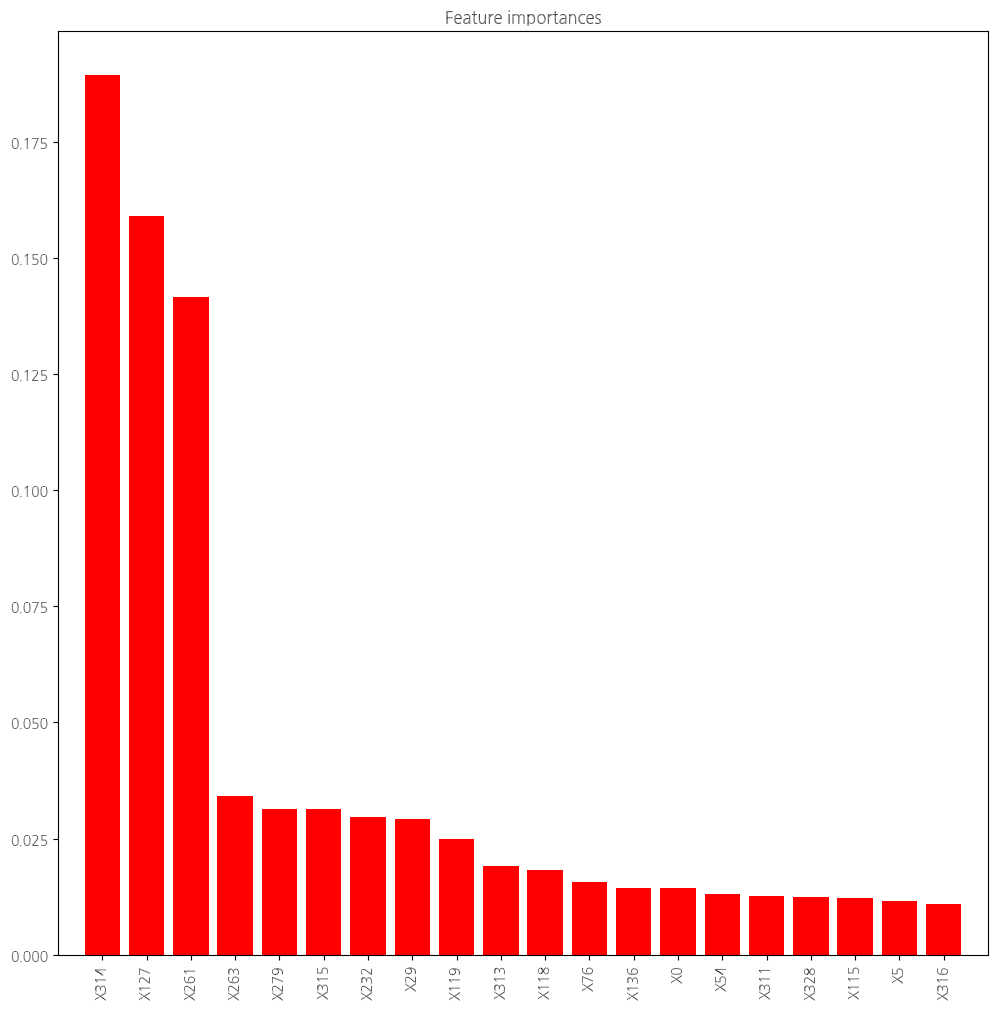

In [21]:
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12, 12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

## 다양한 차원 축소 기법을 활용한 예측 모델링

### 일반적인 적용  

#### 차원 축소 기법의 종류
- Principal Component Analysis [PCA]
- Independent Component Analysis [ICA]
- Truncated SVD [TSVD]
- Gaussian Random Projection [GRP]
- Sparse Random Projection [SRP]
- Non-negative Matrix factorization [NMF]
- Feature Agglomeration [FAG]

#### 데이터 준비

In [22]:
train = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/08_car_manufacturing_test_time_prediction/train.csv")
test = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/08_car_manufacturing_test_time_prediction/test.csv")

y_train = train['y']
train = train.drop('y', axis=1)

#### Label Encoding

In [23]:
for c in train.columns:
  if train[c].dtype == 'object':
    lbl = LabelEncoder()
    lbl.fit(list(train[c].values) + list(test[c].values))
    train[c] = lbl.transform(list(train[c].values))
    test[c] = lbl.transform(list(test[c].values))

#### 차원 축소 방법 적용

In [24]:
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train)
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train)
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train)
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train)
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train)
srp_results_test = srp.transform(test)

# NMF
nmf = NMF(n_components=n_comp, init='nndsvdar', random_state=420)
nmf_results_train = nmf.fit_transform(train)
nmf_results_test = nmf.transform(test)

# FAG
fag = FeatureAgglomeration(n_clusters=n_comp, linkage='ward')
fag_results_train = fag.fit_transform(train)
fag_results_test = fag.transform(test)

In [25]:
dim_reds = list()

train_pca = pd.DataFrame()
test_pca = pd.DataFrame()

train_ica = pd.DataFrame()
test_ica = pd.DataFrame()

train_tsvd = pd.DataFrame()
test_tsvd = pd.DataFrame()

train_grp = pd.DataFrame()
test_grp = pd.DataFrame()

train_srp = pd.DataFrame()
test_srp = pd.DataFrame()

train_nmf = pd.DataFrame()
test_nmf = pd.DataFrame()

train_fag = pd.DataFrame()
test_fag = pd.DataFrame()

for i in range(1, n_comp + 1):
    train_pca['pca_' + str(i)] = pca2_results_train[:, i-1]
    test_pca['pca_' + str(i)] = pca2_results_test[:, i-1]

    train_ica['ica_' + str(i)] = ica2_results_train[:, i-1]
    test_ica['ica_' + str(i)] = ica2_results_test[:, i-1]

    train_tsvd['tsvd_' + str(i)] = tsvd_results_train[:, i-1]
    test_tsvd['tsvd_' + str(i)] = tsvd_results_test[:, i-1]

    train_grp['grp_' + str(i)] = grp_results_train[:, i-1]
    test_grp['grp_' + str(i)] = grp_results_test[:, i-1]

    train_srp['srp_' + str(i)] = srp_results_train[:, i-1]
    test_srp['srp_' + str(i)] = srp_results_test[:, i-1]

    train_nmf['nmf_' + str(i)] = nmf_results_train[:, i-1]
    test_nmf['nmf_' + str(i)] = nmf_results_test[:, i-1]

    train_fag['fag_' + str(i)] = fag_results_train[:, i-1]
    test_fag['fag_' + str(i)] = fag_results_test[:, i-1]


dim_reds.append(('pca', train_pca, test_pca))
dim_reds.append(('ica', train_ica, test_ica))
dim_reds.append(('tsvd', train_tsvd, test_tsvd))
dim_reds.append(('grp', train_grp, test_grp))
dim_reds.append(('srp', train_srp, test_srp))
dim_reds.append(('nmf', train_nmf, test_nmf))
dim_reds.append(('fag', train_fag, test_fag))

#### 복수의 차원 축소 기법 적용에 따른 성능 실험

In [39]:
combs = [combinations(dim_reds, i+1) for i in range(0, len(dim_reds))]

In [40]:
dr_scores = list()
for c1 in combs:
  for c2 in c1:
    train_, test_, id_ = list(), list(), list()
    for k in c2:
      train_.append(k[1])
      test_.append(k[2])
      id_.append(k[0])

    train_x = train.reset_index(drop=True)
    train_.append(train_x)
    test_.append(test)

    train_ = pd.concat(train_, axis=1)
    test_ = pd.concat(test_, axis=1)

############### ElasticNet Model ###############
    model = ElasticNet(alpha=0.014, tol=0.11, l1_ratio=0.9999999,
                       fit_intercept=False, warm_start=True,
                       copy_X=True, precompute=False, positive=False, max_iter=60)
    model.fit(train_, y_train)
    c_score = r2_score(y_train, model.predict(train_))

    dr_scores.append((','.join(id_), c_score))

In [41]:
# ElasticNet 적용 이후 R^2 구하기

model = ElasticNet(alpha=0.014, tol=0.11, l1_ratio=0.9999999,
                   fit_intercept=False, warm_start=True,
                   copy_X=True, precompute=False, positive=False, max_iter=60)
model.fit(train, y_train)
full_score = r2_score(y_train, model.predict(train))
dr_scores.append(('baseline', full_score))

Plotting the graph

In [44]:
for dr_score in dr_scores:
  if dr_score[1] < 0:
    dr_score = (dr_score[0], 0)

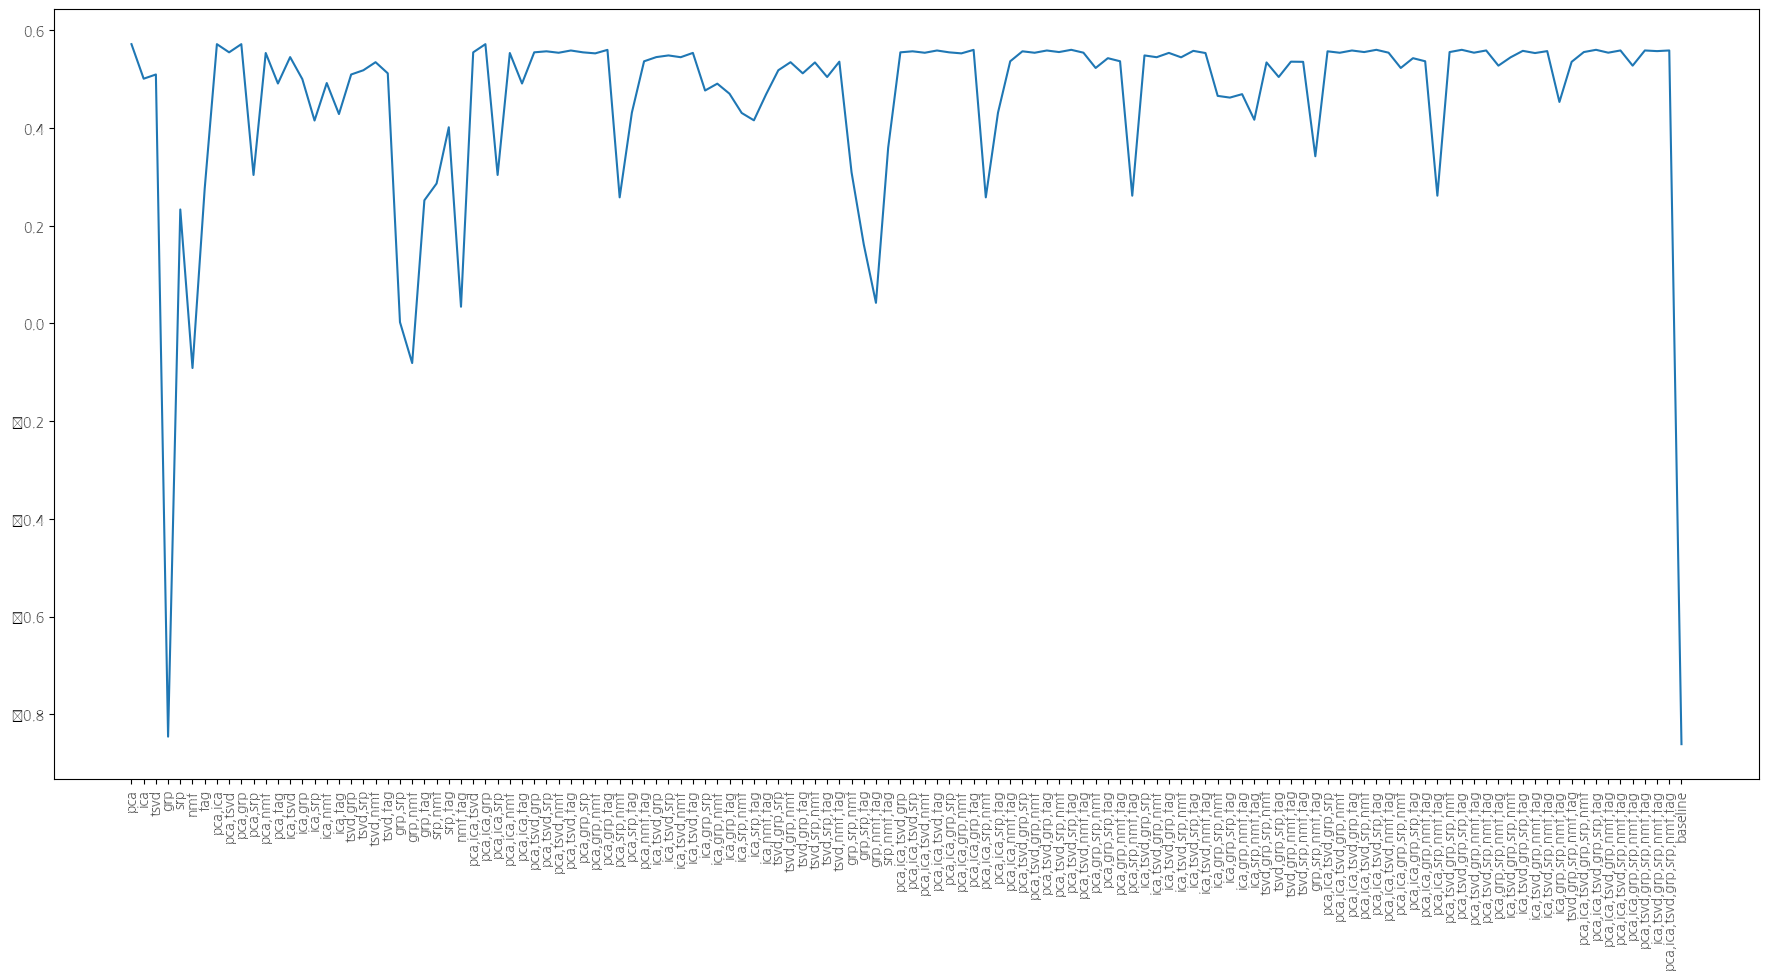

In [45]:
x_axis = [c[0] for c in dr_scores]
y_axis = [c[1] for c in dr_scores]
fig, ax = plt.subplots(figsize=(22, 10))
plt.plot(y_axis)
ax.set_xticks(range(len(x_axis)))
ax.set_xticklabels(x_axis, rotation='vertical')
plt.show()

#### 모델 성능 비교

In [46]:
sorted_id = np.argsort(y_axis)
print("점수 하위 7개 차원 축소 기법 조합: {}".format(np.array(x_axis)[sorted_id[:7]]))
print("점수 상위 7개 차원 축소 기법 조합: {}".format(np.array(x_axis)[sorted_id[-7:]]))

print("\n\n가장 높은 점수를 가지는 조합: {}".format(np.array(x_axis)[sorted_id[-1]]))

점수 하위 7개 차원 축소 기법 조합: ['baseline' 'grp' 'nmf' 'grp,nmf' 'grp,srp' 'nmf,fag' 'grp,nmf,fag']
점수 상위 7개 차원 축소 기법 조합: ['pca,ica,tsvd,srp,fag' 'pca,tsvd,grp,srp,fag' 'pca,ica,tsvd,grp,srp,fag'
 'pca,grp' 'pca,ica,grp' 'pca,ica' 'pca']


가장 높은 점수를 가지는 조합: pca


In [50]:
n_comp = 12

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train)
grp_results_test = grp.fit_transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train)
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train)
ica2_results_test = ica.transform(test)

for i in range(1, n_comp+1):
  train['grp_' + str(i)] = grp_results_train[:, i-1]
  test['grp_' + str(i)] = grp_results_test[:, i-1]

  train['pca_' + str(i)] = pca2_results_train[:, i-1]
  test['pca_' + str(i)] = pca2_results_test[:, i-1]

  train['ica_' + str(i)] = ica2_results_train[:, i-1]
  test['ica_' + str(i)] = ica2_results_test[:, i-1]

y_mean = np.mean(y_train)

In [51]:
import xgboost as xgb

xgb_params = {
    'n_trees': 500,
    'eta': 0.005,
    'max_depth': 6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean,
    'silent': 1
}

dtrain = xgb.DMatrix(train, y_train)
dtest = xgb.DMatrix(test)

cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=700, verbose_eval=50, show_stdv=False)

num_boost_rounds = len(cv_result)
print("num_boost_rounds:", num_boost_rounds)

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_rounds)

[0]	train-rmse:12.63807	test-rmse:12.63876
[50]	train-rmse:11.02162	test-rmse:11.17081
[100]	train-rmse:9.85667	test-rmse:10.17348
[150]	train-rmse:9.01866	test-rmse:9.51245
[200]	train-rmse:8.41759	test-rmse:9.09533
[250]	train-rmse:7.98066	test-rmse:8.83651
[300]	train-rmse:7.65559	test-rmse:8.68002
[350]	train-rmse:7.39951	test-rmse:8.58985
[400]	train-rmse:7.19509	test-rmse:8.54057
[450]	train-rmse:7.01525	test-rmse:8.51802
[500]	train-rmse:6.86416	test-rmse:8.50879
[550]	train-rmse:6.73520	test-rmse:8.50714
[600]	train-rmse:6.61679	test-rmse:8.50951
[650]	train-rmse:6.50811	test-rmse:8.51274
[699]	train-rmse:6.41149	test-rmse:8.51782
num_boost_rounds: 700
